# Q2 - Regression analysis: NHL goals

Use Bayes Rule and Multinomial Regressions to estimate the in-game winning probability in terms of the home team

The likehood that a home team win will eventually win the game can be expressed as

$$ p(W_g| score_{g,t} ) = \frac{p(g_g| SX_{g,t} ) p(W_g)}{ p(SX_{g,t} | W_g) p(W_g) +  p(SX_{g,t} | \overline{W_g}) p( \overline{W_g}) } $$

where the subscript $g$ denotes the game and $t$ denotes minutes remaining in regulation time. The following terms denote:

* $p(W_g| SX_{g,t})$: the posterior probability of a win the $g^th$ game with $t$ minutes remaining 
* $p(W_g$: the prior probability of a win
* $p(SX_{g,t} |W_g)$ and $p(SX_{g,t}  | \overline{W_g})$: inverse conditional probabilities


* Provide an in game winning probability plot for game number 21202

## Data
* The unit of observation is a season-game-goal
* The secstart column is the number of seconds from the start of the game
* The hgoals and agoals columns are the number of goals scored for by the home and away team prior at time $t$


In [1]:
import os
import sys
import pandas
import numpy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import statsmodels.api as sm

pandas.set_option('display.notebook_repr_html', True)
pandas.set_option('display.max_columns', 40)
pandas.set_option('display.max_rows', 25)
pandas.set_option('precision', 4)

C:\ProgramData\Anaconda3\envs\my_root\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dm = pandas.read_csv('NHLSeasonGameGoals.csv')
dm.head()

,gamedate,season,gameno,goalno,period,secstart,gteam,hteam,ateam,wteam,hgoals,agoals
0,2014-12-22,2014,20500,1,1,394,home,VAN,ARI,home,0,0
1,2014-12-22,2014,20500,2,1,1037,home,VAN,ARI,home,1,0
2,2014-12-22,2014,20500,3,1,1158,home,VAN,ARI,home,2,0
3,2014-12-22,2014,20500,4,2,1301,home,VAN,ARI,home,3,0
4,2014-12-22,2014,20500,5,2,1939,home,VAN,ARI,home,4,0


### Sort dataframe
* season-game-goal observations

In [3]:
dm = dm.sort_values(by=['season', 'gameno', 'goalno'])
dm.head()

,gamedate,season,gameno,goalno,period,secstart,gteam,hteam,ateam,wteam,hgoals,agoals
0,2014-12-22,2014,20500,1,1,394,home,VAN,ARI,home,0,0
1,2014-12-22,2014,20500,2,1,1037,home,VAN,ARI,home,1,0
2,2014-12-22,2014,20500,3,1,1158,home,VAN,ARI,home,2,0
3,2014-12-22,2014,20500,4,2,1301,home,VAN,ARI,home,3,0
4,2014-12-22,2014,20500,5,2,1939,home,VAN,ARI,home,4,0


### Generate variables

In [5]:
dm['dgoals'] = dm.hgoals - dm.agoals
dm['dgoals'] = numpy.where(dm.dgoals>3, 3, dm.dgoals)
dm['dgoals'] = numpy.where(dm.dgoals<-3, -3, dm.dgoals)

dm['minstart'] = (dm.secstart/60).astype('int')

dm['secrem'] = 3600 - dm.secstart
dm['lnsecrem'] = numpy.log(dm['secrem'])

## Summary statistics

In [6]:
dm.describe()

,season,gameno,goalno,period,secstart,hgoals,agoals,dgoals,minstart,secrem,lnsecrem
count,3615.0,3615.0000,3615.0000,3615.0000,3615.0000,3615.0000,3615.0000,3615.0000,3615.0000,3615.0000,3615.0000
mean,2014.0,20846.0965,3.5087,2.0769,1922.4539,1.3959,1.1950,0.1734,31.5452,1677.5461,7.0245
std,0.0,203.8264,2.0776,0.8030,1038.4533,1.4037,1.2225,1.4402,17.2979,1038.4533,1.1971
min,2014.0,20500.0000,1.0000,1.0000,60.0000,0.0000,0.0000,-3.0000,1.0000,1.0000,0.0000
25%,2014.0,20669.0000,2.0000,1.0000,1053.5000,0.0000,0.0000,-1.0000,17.0000,783.0000,6.6631
50%,2014.0,20841.0000,3.0000,2.0000,1933.0000,1.0000,1.0000,0.0000,32.0000,1667.0000,7.4188
75%,2014.0,21019.5000,5.0000,3.0000,2817.0000,2.0000,2.0000,1.0000,46.0000,2546.5000,7.8425
max,2014.0,21202.0000,12.0000,3.0000,3599.0000,8.0000,6.0000,3.0000,59.0000,3540.0000,8.1719


### Dataframes: home win and home loss

In [7]:
d1 = dm[dm.wteam=='home']
d0 = dm[dm.wteam=='away']

## Conditional likelihood analysis
* Mean score differential throughout the progression of games

In [8]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_notebook
output_notebook()

TOOLS = 'pan,wheel_zoom,box_zoom,reset,save,box_select'

y1 = d1.groupby('minstart')['dgoals'].mean()
y0 = d0.groupby('minstart')['dgoals'].mean()
x = list(range(1, 60))

p1 = figure(title='Mean point differential throughout the progression of games.', 
            x_range=[0,60], y_range=[-3, 3], 
            x_axis_label = 'Minutes from game start', y_axis_label = 'Goal differential', tools=TOOLS)

p1.line(x, y1, color='navy', alpha=1, line_width=3, legend='Home team wins')
p1.line(x, y0, color='firebrick', alpha=1, line_width=3, legend='Home team losses')
p1.ray([0], [0], color='black', length=300, angle=0, line_width=1)
p1.legend.location = 'bottom_left'
show(gridplot(p1, ncols=1, nrows=1, plot_width=800, plot_height=500))

Loading BokehJS ...

### Estimate inverse conditional probabilities

In [13]:
m1 = sm.MNLogit(d1.dgoals, sm.add_constant(d1.lnsecrem)).fit()
m0 = sm.MNLogit(d0.dgoals, sm.add_constant(d0.lnsecrem)).fit()

Optimization terminated successfully.
         Current function value: 1.554964
         Iterations 10
Optimization terminated successfully.
         Current function value: 1.480198
         Iterations 11


### MNL regression results: possession team wins

In [18]:
m1.params

,0,1,2,3,4,5
const,2.6451,5.9052,1.8159,8.0988,9.0797,9.1142
lnsecrem,-0.0855,-0.3179,0.3752,-0.5067,-0.7100,-0.7539


### MNL regression results: possession team losses

In [19]:
m0.params

,0,1,2,3,4,5
const,0.5445,-0.2077,-5.4630,-3.0393,-5.0019,-8.4300
lnsecrem,0.0538,0.2476,1.0022,0.5288,0.5727,0.5473


### Generate prediction dataframe

In [100]:
secstart = list(range(1,3600))
gameno = dm.gameno.unique()
dn = dm[['gamedate', 'hteam', 'ateam', 'gameno', 'secstart', 'dgoals']]

idx = pandas.MultiIndex.from_product([gameno, secstart], names=['gameno', 'secstart'])
dp = pandas.DataFrame(index=idx)
dp = dp.reset_index()

dp = pandas.merge(dp, dn, on=['gameno', 'secstart'], how='left')
dp['dgoals'] = dp.groupby(['gameno'])['dgoals'].bfill()
dp['dgoals'] = dp.groupby(['gameno'])['dgoals'].ffill()
dp['dgoals'] = dp.dgoals.astype('int')

dp['gamedate'] = dp.groupby(['gameno'])['gamedate'].bfill()
dp['gamedate'] = dp.groupby(['gameno'])['gamedate'].ffill()

dp['hteam'] = dp.groupby(['gameno'])['hteam'].bfill()
dp['hteam'] = dp.groupby(['gameno'])['hteam'].ffill()

dp['ateam'] = dp.groupby(['gameno'])['ateam'].bfill()
dp['ateam'] = dp.groupby(['gameno'])['ateam'].ffill()

dp['match'] = dp.gamedate + '_' + dp.hteam + '_at_' + dp.ateam

dp['minstart'] = (dp.secstart/60).astype('int')
dp['secrem'] = 3600 - dp.secstart
dp['lnsecrem'] = numpy.log(dp['secrem'])

dp = dp[['match', 'gamedate', 'hteam', 'ateam', 'gameno', 'secstart', 'minstart', 'secrem', 'lnsecrem', 'dgoals']]
dp = dp.sort_values(by=['gameno', 'secstart'])
print(len(dp))
dp.head()

2512102


,match,gamedate,hteam,ateam,gameno,secstart,minstart,secrem,lnsecrem,dgoals
0,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,1,0,3599,8.1884,0
1,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,2,0,3598,8.1881,0
2,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,3,0,3597,8.1879,0
3,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,4,0,3596,8.1876,0
4,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,5,0,3595,8.1873,0


### Predicted Bayes Factors across score and time remaining states

In [101]:
b1 = pandas.DataFrame(m1.predict(sm.add_constant(dp.lnsecrem)))
b0 = pandas.DataFrame(m0.predict(sm.add_constant(dp.lnsecrem)))
bf = b1/b0

#change column names to be consistent with score states
bf.columns = bf.columns - 3

bf.head()

,-3,-2,-1,0,1,2,3
0,0.1124,0.2934,0.4944,0.9601,1.6052,4.0232,110.3214
1,0.1123,0.2933,0.4944,0.9601,1.6053,4.0238,110.3390
2,0.1123,0.2933,0.4944,0.9600,1.6055,4.0245,110.3565
3,0.1123,0.2932,0.4944,0.9600,1.6056,4.0251,110.3741
4,0.1123,0.2932,0.4943,0.9600,1.6057,4.0257,110.3917


### Merge Bayes Factor estimates into prediction dataframe

In [102]:
dr = pandas.merge(dp, bf, left_index=True,right_index=True)
del dp
dr.head()

,match,gamedate,hteam,ateam,gameno,secstart,minstart,secrem,lnsecrem,dgoals,-3,-2,-1,0,1,2,3
0,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,1,0,3599,8.1884,0,0.1124,0.2934,0.4944,0.9601,1.6052,4.0232,110.3214
1,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,2,0,3598,8.1881,0,0.1123,0.2933,0.4944,0.9601,1.6053,4.0238,110.3390
2,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,3,0,3597,8.1879,0,0.1123,0.2933,0.4944,0.9600,1.6055,4.0245,110.3565
3,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,4,0,3596,8.1876,0,0.1123,0.2932,0.4944,0.9600,1.6056,4.0251,110.3741
4,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,5,0,3595,8.1873,0,0.1123,0.2932,0.4943,0.9600,1.6057,4.0257,110.3917


### Identify appropriate Bayes Factor for game-goal state

In [103]:
dr['bf'] = 0
for s in [-3, -2, -1, 0, 1, 2, 3]:
    dr['bf'] = numpy.where(dr.dgoals==s, dr[s], dr.bf)
dr.head()

,match,gamedate,hteam,ateam,gameno,secstart,minstart,secrem,lnsecrem,dgoals,-3,-2,-1,0,1,2,3,bf
0,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,1,0,3599,8.1884,0,0.1124,0.2934,0.4944,0.9601,1.6052,4.0232,110.3214,0.9601
1,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,2,0,3598,8.1881,0,0.1123,0.2933,0.4944,0.9601,1.6053,4.0238,110.3390,0.9601
2,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,3,0,3597,8.1879,0,0.1123,0.2933,0.4944,0.9600,1.6055,4.0245,110.3565,0.9600
3,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,4,0,3596,8.1876,0,0.1123,0.2932,0.4944,0.9600,1.6056,4.0251,110.3741,0.9600
4,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,5,0,3595,8.1873,0,0.1123,0.2932,0.4943,0.9600,1.6057,4.0257,110.3917,0.9600


### Set priors

In [104]:
dr['priorprob'] = 0.5
dr['priorodds'] = 0.5 / (1 - dr.priorprob)

## Calculate posterior odds and probabilities (Bayes Rule)

In [105]:
dr['postodds'] =  dr['priorodds'] * dr['bf']
dr['postprob'] =  dr.postodds / (1 + dr.postodds)
dr.head(5)

,match,gamedate,hteam,ateam,gameno,secstart,minstart,secrem,lnsecrem,dgoals,-3,-2,-1,0,1,2,3,bf,priorprob,priorodds,postodds,postprob
0,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,1,0,3599,8.1884,0,0.1124,0.2934,0.4944,0.9601,1.6052,4.0232,110.3214,0.9601,0.5,1.0,0.9601,0.4898
1,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,2,0,3598,8.1881,0,0.1123,0.2933,0.4944,0.9601,1.6053,4.0238,110.3390,0.9601,0.5,1.0,0.9601,0.4898
2,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,3,0,3597,8.1879,0,0.1123,0.2933,0.4944,0.9600,1.6055,4.0245,110.3565,0.9600,0.5,1.0,0.9600,0.4898
3,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,4,0,3596,8.1876,0,0.1123,0.2932,0.4944,0.9600,1.6056,4.0251,110.3741,0.9600,0.5,1.0,0.9600,0.4898
4,2014-12-22_VAN_at_ARI,2014-12-22,VAN,ARI,20500,5,0,3595,8.1873,0,0.1123,0.2932,0.4943,0.9600,1.6057,4.0257,110.3917,0.9600,0.5,1.0,0.9600,0.4898


### In-game win probability plots

In [137]:
d1.gamedate.unique()[0]

'2014-12-22'

### Matplotlib

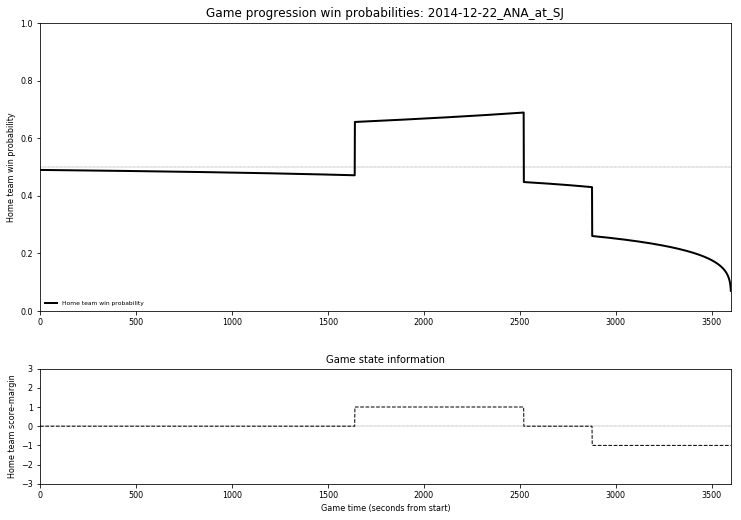

In [153]:
%matplotlib inline

d1 = dr[dr['gameno']==20501]

_match = d1.match.unique()[0]

plt.rc('axes', grid=False )

fig = plt.figure(facecolor='white', figsize=(12, 8))

ax1 = fig.add_axes(rect1, facecolor='white')
ax2 = fig.add_axes(rect2, facecolor='white', sharex=ax1)

ax1.tick_params(axis='y', labelsize=8)
ax1.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.tick_params(axis='x', labelsize=8)
ax1.set_ylim([0,1])
ax2.set_ylim([-3, 3])
ax1.set_xlim([0,3600])
ax2.set_yticks(ticks=[-3, -2, -1, 0, 1, 2, 3])

_title = 'Game progression win probabilities: ' + _match 
ax1.set_title(_title, fontsize=12)
ax1.set_ylabel('Home team win probability', fontsize=8)
ax2.set_title('Game state information', fontsize=10, multialignment='center')
ax2.set_ylabel('Home team score-margin', fontsize=8, multialignment='center')
ax2.set_xlabel('Game time (seconds from start)', fontsize=8)

# plot lines
ax1.plot(d1.secstart, d1.postprob  , marker='', linestyle='-' , 
         linewidth=2, color='black',  
         label='Home team win probability')
ax1.axhline(y=.5, c="black", linewidth=0.25, linestyle='--', zorder=0)


ax2.plot(d1.secstart, d1.dgoals, linestyle='--', linewidth=1.0, color='black', zorder=0)
ax2.axhline(y=0, c="black", linewidth=0.25, linestyle='--', zorder=0)
legend = ax1.legend(loc='lower left', shadow=False, fontsize=6, frameon=False)